# Extra Credit for HW3: Compare similarly complex DenseNet and ResNet to see which has higher accuracy on CIFAR-10

#### Conclusion:

Based on the below characteristics of the similarly complex models, DenseNet is able to achieve a higher validation accuracy than ResNet.

##### DenseNet:

Training Time: 0:13:43.704113

Computational complexity: 284.92 MMac

Number of parameters: 11.4 M 

Val Accuracy: 0.7910

##### ResNet-18:

Training Time: 0:05:50.575383

Computational complexity: 297.53 MMac

Number of parameters: 11.18 M

Val Accuracy: 0.74

## Setup

In [1]:
# import libraries
from tqdm import tqdm
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split, Subset

import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from ptflops import get_model_complexity_info

import torchvision
from torchvision import transforms, datasets
from torchmetrics.classification import MulticlassAccuracy, BinaryAccuracy
from torchmetrics import ConfusionMatrix
from datetime import datetime

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Import Datasets
cifar_trainset = datasets.CIFAR10(root='./data',
                                  train=True,
                                  download=True,
                                  transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Resize(size=64),
                                    transforms.Normalize((0.4734), (0.2453))
                                    ])
)
cifar_testset = datasets.CIFAR10(root='./data',
                                 train=False,
                                 download=True,
                                 transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Resize(size=64),
                                    transforms.Normalize((0.4734), (0.2453))
                                    ])
)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
image, label = cifar_trainset[0]
image.shape

torch.Size([3, 64, 64])

In [5]:
# Seperate train and val sets
cifar_train, cifar_val = random_split(cifar_trainset, [0.8, 0.2])
trainLoader = DataLoader(cifar_train, batch_size=32, shuffle=True)
valLoader = DataLoader(cifar_val, batch_size=32, shuffle=False)
testLoader = DataLoader(cifar_testset, batch_size=32, shuffle=False)

In [6]:
# # Find mean and std for normalization
# loader = DataLoader(cifar_trainset, batch_size=len(cifar_trainset), num_workers=1)
# data = next(iter(loader))
# data[0].mean(), data[0].std()

In [7]:
# Define train_step function
def train_step(model: nn.Module,
               data_loader: DataLoader,
               loss_fn: nn.Module,
               optim: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device):
    """Performs training step on a dataloader batch"""
    train_loss, train_acc = 0, 0
    model.train()
    for batch, (x, y) in enumerate(data_loader):
        # Move data to device
        x, y = x.to(device), y.to(device)
        
        # Forward pass (outputs log likelihood for each class)
        y_pred = model(x)
        # Calculate Loss/Acc of batch
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        # argmax is used to convert from log likelihood to prediction labels
        
        # Zero the gradience for optimizer
        optim.zero_grad()
        
        # Backpropagate loss
        loss.backward()
        
        # Step optimizer based on loss
        optim.step()
        
        acc = accuracy_fn(y_pred.argmax(dim=1), y)
        train_acc += acc.item()
        
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    return train_loss, train_acc

In [8]:
# Define val_step function
def val_step(model: nn.Module,
             data_loader: DataLoader,
             loss_fn: nn.Module,
             accuracy_fn,
             device: torch.device):
    """Performs validation step on val dataloader"""
    val_loss, val_acc = 0, 0
    model.eval()
    
    # Turn on inference mode context manager (increases speed)
    with torch.inference_mode():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            # Forward pass
            val_pred = model(x)
            
            # Calculate loss
            loss = loss_fn(val_pred, y)
            val_loss += loss.item()
            
            acc = accuracy_fn(val_pred.argmax(dim=1), y)
            val_acc += acc.item()
            
        val_loss /= len(data_loader)
        val_acc /= len(data_loader)
        return val_loss, val_acc

In [9]:
# Create train function
def train(model: nn.Module,
          train_dataloader: DataLoader,
          val_dataloader: DataLoader,
          optim: torch.optim.Optimizer,
          loss_fn: nn.Module,
          accuracy_fn,
          epochs: int,
          device: torch.device,
          verbose = False):
    results = {"Train Loss": [],
               "Train Accuracy": [],
               "Val Loss": [],
               "Val Accuracy": []}
    for epoch in tqdm(range(epochs), disable=verbose):
        train_loss, train_acc = train_step(model=model,
                                           data_loader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optim=optim,
                                           accuracy_fn=accuracy_fn,
                                           device=device)
        val_loss, val_acc = val_step(model=model,
                                     data_loader=val_dataloader,
                                     loss_fn=loss_fn,
                                     accuracy_fn=accuracy_fn,
                                     device=device)
        
        print(f"Epoch: {epoch+1}\n--------------- "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Accuracy: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Accuracy: {val_acc:.4f}"
             )
        results["Train Loss"].append(train_loss)
        results["Train Accuracy"].append(train_acc)
        results["Val Loss"].append(val_loss)
        results["Val Accuracy"].append(val_acc)
    return results

In [10]:
def print_train_time(start, end, device: torch.device=None):
    total_time = end - start
    print(f"{device} Training Time: {total_time:.3f} seconds")
    return total_time

In [11]:
# Plot history
from typing import Tuple, Dict, List
def plot_history(results: Dict[str, List[float]]):
    loss = results["Train Loss"]
    val_loss = results["Val Loss"]
    acc = results["Train Accuracy"]
    val_acc = results["Val Accuracy"]
    
    epochs = range(len(results["Train Loss"]))
    
    plt.figure()
    # Plot loss and accuracy
    plt.plot(epochs, loss, label="Train Loss")
    plt.plot(epochs, acc, label="Train Accuracy")
    plt.plot(epochs, val_acc, label="Val Accuracy")
    plt.title("Model History")
    plt.xlabel("Epochs")
    plt.legend()

## ResNet-18

In [18]:
# Build ResNet version from lecture, using D2L code
class Residual(nn.Module):
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [19]:
class ResNet(nn.Module):
    def block(self, num_residuals, num_channels, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                blk.append(Residual(num_channels))
        return nn.Sequential(*blk)

    def __init__(self, arch, lr=0.1, num_classes=10, ):
        super().__init__()
        self.stem = nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.body = nn.Sequential()
        for i, b in enumerate(arch):
            self.body.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
        self.body.add_module("AVG Adaptive Pool", nn.AdaptiveAvgPool2d((1, 1)))
        
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(num_classes)
        )
        
        self.net = nn.Sequential(
            self.stem,
            self.body,
            self.head,
        )
    def forward(self, x):
        x = self.stem(x)
        x = self.body(x)
        x = self.head(x)
        return x

In [15]:
P3a_model = ResNet(((2, 64), (2, 128), (2, 256), (2, 512))).to(device)
P3a_model(torch.randn(1, 3, 64, 64).to(device))

tensor([[-0.2125, -0.5688,  0.1475,  0.6222,  0.0256, -0.4285,  0.3562, -0.0945,
          0.0902,  0.1118]], device='cuda:0', grad_fn=<AddmmBackward0>)

 10%|████████▎                                                                          | 1/10 [00:35<05:20, 35.63s/it]

Epoch: 1
--------------- Train Loss: 1.5410, Train Accuracy: 0.4345, Val Loss: 1.2523, Val Accuracy: 0.5479


 20%|████████████████▌                                                                  | 2/10 [01:10<04:42, 35.35s/it]

Epoch: 2
--------------- Train Loss: 1.0868, Train Accuracy: 0.6090, Val Loss: 1.0442, Val Accuracy: 0.6158


 30%|████████████████████████▉                                                          | 3/10 [01:45<04:05, 35.12s/it]

Epoch: 3
--------------- Train Loss: 0.8484, Train Accuracy: 0.6885, Val Loss: 0.9218, Val Accuracy: 0.6736


 40%|█████████████████████████████████▏                                                 | 4/10 [02:22<03:33, 35.61s/it]

Epoch: 4
--------------- Train Loss: 0.6743, Train Accuracy: 0.7489, Val Loss: 0.8411, Val Accuracy: 0.6869


 50%|█████████████████████████████████████████▌                                         | 5/10 [02:56<02:56, 35.23s/it]

Epoch: 5
--------------- Train Loss: 0.5299, Train Accuracy: 0.7977, Val Loss: 0.7499, Val Accuracy: 0.7256


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [03:31<02:20, 35.09s/it]

Epoch: 6
--------------- Train Loss: 0.4049, Train Accuracy: 0.8366, Val Loss: 0.7569, Val Accuracy: 0.7288


 70%|██████████████████████████████████████████████████████████                         | 7/10 [04:06<01:45, 35.10s/it]

Epoch: 7
--------------- Train Loss: 0.3029, Train Accuracy: 0.8693, Val Loss: 0.9208, Val Accuracy: 0.7049


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [04:41<01:09, 34.98s/it]

Epoch: 8
--------------- Train Loss: 0.2295, Train Accuracy: 0.8946, Val Loss: 0.8587, Val Accuracy: 0.7353


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [05:15<00:34, 34.86s/it]

Epoch: 9
--------------- Train Loss: 0.1612, Train Accuracy: 0.9149, Val Loss: 0.9522, Val Accuracy: 0.7245


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:50<00:00, 35.06s/it]

Epoch: 10
--------------- Train Loss: 0.1271, Train Accuracy: 0.9292, Val Loss: 0.9186, Val Accuracy: 0.7448
Training Time: 0:05:50.575383


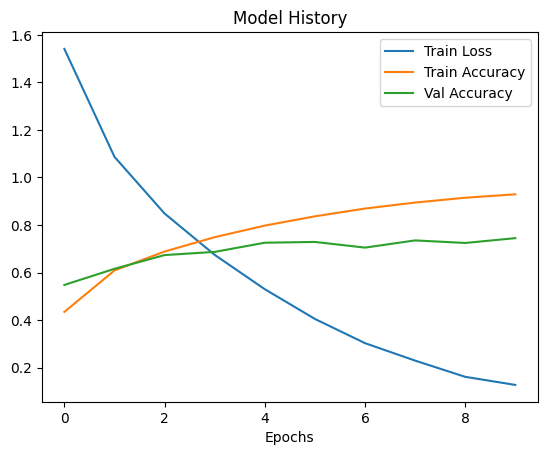

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=P3a_model.parameters(),
                            lr=0.1)
accuracy_fn = MulticlassAccuracy(num_classes=10).to(device)
epochs = 10

start_time = datetime.now()
P3a_model_history = train(model=P3a_model,
                     train_dataloader=trainLoader,
                     val_dataloader=valLoader,
                     optim=optimizer,
                     loss_fn=loss_fn,
                     accuracy_fn=accuracy_fn,
                     epochs=epochs,
                     device=device,
                     verbose=False)
stop_time = datetime.now()
print(f"Training Time: {stop_time - start_time}")
plot_history(P3a_model_history)

In [ ]:
# CLEARED OUTPUT FOR SUBMISSION DUE TO LONG WARNING MESSAGE
with torch.cuda.device(0):
  macs, params = get_model_complexity_info(P3a_model, (3, 64, 64), as_strings=True,
                                           print_per_layer_stat=False, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

## DenseNet

In [12]:
# Build DenseNet model from D2L textbook code
def conv_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=3, padding=1))
class DenseBlock(nn.Module):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate input and output of each block along the channels
            X = torch.cat((X, Y), dim=1)
        return X
def transition_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

In [13]:
blk = DenseBlock(2, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

C:\Users\stanl\anaconda3\envs\pytorch_cuda\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([4, 23, 8, 8])

In [14]:
class DenseNet(nn.Module):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    def __init__(self, num_channels=64, growth_rate=32, arch=(4, 4, 4, 4),
             lr=0.1, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(self.b1())
        for i, num_convs in enumerate(arch):
            self.net.add_module(f'dense_blk{i+1}', DenseBlock(num_convs,
                                                              growth_rate))
            # The number of output channels in the previous dense block
            num_channels += num_convs * growth_rate
            # A transition layer that halves the number of channels is added
            # between the dense blocks
            if i != len(arch) - 1:
                num_channels //= 2
                self.net.add_module(f'tran_blk{i+1}', transition_block(
                    num_channels))
        self.net.add_module('last', nn.Sequential(
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.LazyLinear(num_classes))
                           )
    def forward(self, x):
        x = self.net(x)
        return x

In [22]:
# NEED TO DEBUG DENSENET MODEL, WILL SEND WHEN FINISHED
DenseNet_model = DenseNet(arch=(6, 16, 18, 24)).to(device)
DenseNet_model(torch.randn(1, 3, 64, 64).to(device))

tensor([[ 0.4171, -0.2354,  0.0058, -0.3055,  0.2153, -0.1027,  0.2784, -0.2422,
         -0.1048, -0.0803]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [23]:
# CLEARED OUTPUT FOR SUBMISSION DUE TO LONG WARNING MESSAGE
with torch.cuda.device(0):
  macs, params = get_model_complexity_info(DenseNet_model, (3, 64, 64), as_strings=True,
                                           print_per_layer_stat=False, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Computational complexity:       284.92 MMac
Number of parameters:           11.4 M  


 10%|████████▎                                                                          | 1/10 [01:21<12:11, 81.27s/it]

Epoch: 1
--------------- Train Loss: 1.5973, Train Accuracy: 0.4200, Val Loss: 1.3099, Val Accuracy: 0.5135


 20%|████████████████▌                                                                  | 2/10 [02:42<10:50, 81.29s/it]

Epoch: 2
--------------- Train Loss: 1.1371, Train Accuracy: 0.5878, Val Loss: 0.9877, Val Accuracy: 0.6281


 30%|████████████████████████▉                                                          | 3/10 [04:05<09:35, 82.20s/it]

Epoch: 3
--------------- Train Loss: 0.8866, Train Accuracy: 0.6776, Val Loss: 0.8047, Val Accuracy: 0.6954


 40%|█████████████████████████████████▏                                                 | 4/10 [05:27<08:12, 82.17s/it]

Epoch: 4
--------------- Train Loss: 0.7214, Train Accuracy: 0.7352, Val Loss: 0.8668, Val Accuracy: 0.6803


 50%|█████████████████████████████████████████▌                                         | 5/10 [06:49<06:49, 81.96s/it]

Epoch: 5
--------------- Train Loss: 0.6129, Train Accuracy: 0.7722, Val Loss: 0.7087, Val Accuracy: 0.7345


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [08:11<05:28, 82.05s/it]

Epoch: 6
--------------- Train Loss: 0.5242, Train Accuracy: 0.8013, Val Loss: 0.7083, Val Accuracy: 0.7400


 70%|██████████████████████████████████████████████████████████                         | 7/10 [09:32<04:04, 81.59s/it]

Epoch: 7
--------------- Train Loss: 0.4493, Train Accuracy: 0.8250, Val Loss: 0.6094, Val Accuracy: 0.7720


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [10:54<02:43, 81.70s/it]

Epoch: 8
--------------- Train Loss: 0.3910, Train Accuracy: 0.8491, Val Loss: 0.6320, Val Accuracy: 0.7675


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [12:18<01:22, 82.50s/it]

Epoch: 9
--------------- Train Loss: 0.3255, Train Accuracy: 0.8668, Val Loss: 0.6206, Val Accuracy: 0.7711


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [13:43<00:00, 82.37s/it]

Epoch: 10
--------------- Train Loss: 0.2770, Train Accuracy: 0.8795, Val Loss: 0.5878, Val Accuracy: 0.7910
Training Time: 0:13:43.704113


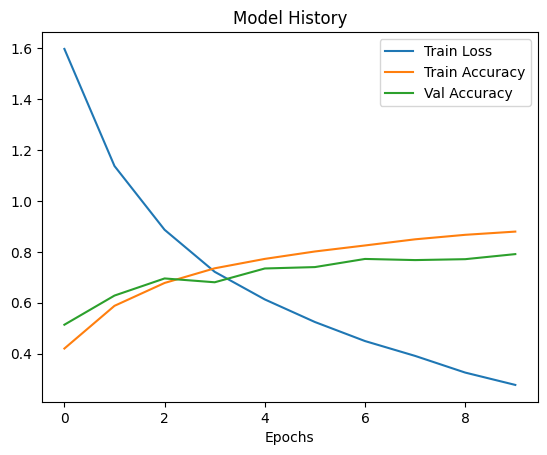

In [24]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=DenseNet_model.parameters(),
                            lr=0.1)
accuracy_fn = MulticlassAccuracy(num_classes=10).to(device)
epochs = 10

start_time = datetime.now()
DenseNet_model_history = train(model=DenseNet_model,
                     train_dataloader=trainLoader,
                     val_dataloader=valLoader,
                     optim=optimizer,
                     loss_fn=loss_fn,
                     accuracy_fn=accuracy_fn,
                     epochs=epochs,
                     device=device,
                     verbose=False)
stop_time = datetime.now()
print(f"Training Time: {stop_time - start_time}")
plot_history(DenseNet_model_history)